In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<h1>1) Data Description</h1>

This project utilizes two datasets provided as CSV files: <code>players.csv</code> and <code>sessions.csv</code>. The data was collected from a Minecraft research server run by a Computer Science group at UBC, where <code>players.csv</code> contains information on individual players, while <code>sessions.csv</code> contains information on individual play sessions.

<h2>Dataset Summaries</h2>
<h3><code>players.csv</code></h3>
<ul>
    <li>196 observations, each representing a unique player</li>
    <li>7 columns/variables</li>
    <li>Variable Details:
    <ol>
        <li>experience (character): A categorical variable describing the player's experience (e.g., 'Pro', 'Veteran', 'Amateur', 'Regular').</li>
        <li>subscribe (boolean/logical vector): A boolean variable (True/False) indicating if the player is subscribed to a game-related newsletter.</li>
        <li>hashedEmail (character): A categorical variable serving as a unique identifier for each player.</li>
        <li>played_hours (double): A quantitative variable for the total number of hours played.</li>
        <li>name (character): A categorical variable for the player's in-game name.</li>
        <li>gender (character): A categorical variable for the player's gender.</li>
        <li>Age (double): A quantitative variable for the player's age.</li>
    </ol>
    </li>
</ul>

<h3><code>sessions.csv</code></h3>
<ul>
    <li>1,535 observations, each representing one play session</li>
    <li>5 columns/variables</li>
    <li>Variable Details:
        <ol>
            <li>hashedEmail (character): A categorical variable serving as a unique identifier for each player.</li>
            <li>start_time (character): The start time of each session as a categorical variable, stored in plain text.</li>
            <li>end_time (character): The end time of each session as a categorical variable, stored in plain text.</li>
            <li>original_start_time (double): The start time of each session as a quantitative variable, stored as a Unix timestamp.</li>
            <li>original_end_time (double): The end time of each session as a quantitative variable, stored as a Unix timestamp.</li>
        </ol>
    </li>
</ul>

<h2>Issues within the Data</h2>

Upon initial analysis of the data, there are a few potential errors that will need to be addressed. <ul> <li>
<code>players.csv</code>'s <code>Age</code> column contains 2 missing/NA values, and <code>sessions.csv</code>'s <code>end_time</code> and <code>original_end_time</code> columns each have 2 missing/NA values. Because these errors are fairly minor, we can choose to remove them or perform mean imputation.</li> <li> Additionally, <code>start_time</code> and <code>end_time</code> would likely need to be converted to a numerical form for any time-based analysis, but we are already given their Unix 'original' counterparts. </li> <li> Finally, and most glaringly, some data is highly skewed. <code>played_hours</code>, for example, has a mean of 5.85 yet a median of 0.10, implying that most players have very few hours while a few players have very many hours. This trend continues into the experience variable as well, where there are significantly more Amateurs (63) than Pros (14). </li></ul>

In [35]:
players_hours_stats <- players |>
    select(played_hours) |>
    summarise(
        mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
        median_played_hours = median(played_hours, na.rm = TRUE))

players_experience_stats <- players |>
    group_by(experience) |>
    summarize(count = n())

players_hours_stats
players_experience_stats

mean_played_hours,median_played_hours
<dbl>,<dbl>
5.85,0.1


experience,count
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


<h1>2) Questions</h1>

<strong>Broad Question</strong>: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?

<strong>Specific Question</strong>: Can a player's experience level, total hours played, age, and gender be used to predict whether they will subscribe to the game-related newsletter in the dataset?

The <code>players.csv</code> dataset is well suited to answer this question because it gives us all relevant information, including the reponse/explanatory variables. It's important to note that this is a binary classification problem, and <code>sessions.csv</code> is not immediately required for this specific question.

<h1>3) Exploratory Data Analysis and Visualization</h1>

In [39]:
library(ggplot2)

We can start by making a few basic, overarching plots of our dataset to see if there's anything that is immediately interesting. From the below plots, we can gather the following:
<ul>
    <li>The player base is young; players are mostly clustered between ages 15 and 25.</li>
    <li>As mentioned earlier, the hours played of each player is heavily skewed. The vast majority of players played less than 10 hours, while a few users have played 100+.</li>
    <li>There are roughly an equal amount of veteran, regular, and beginner players. Overall, there are many amateurs, and few pros.</li>
    <li>There are significantly more non-subscribers than subscribers. <strong>Because of this, accuracy alone may be a misleading metric.</strong></li>
</ul>

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


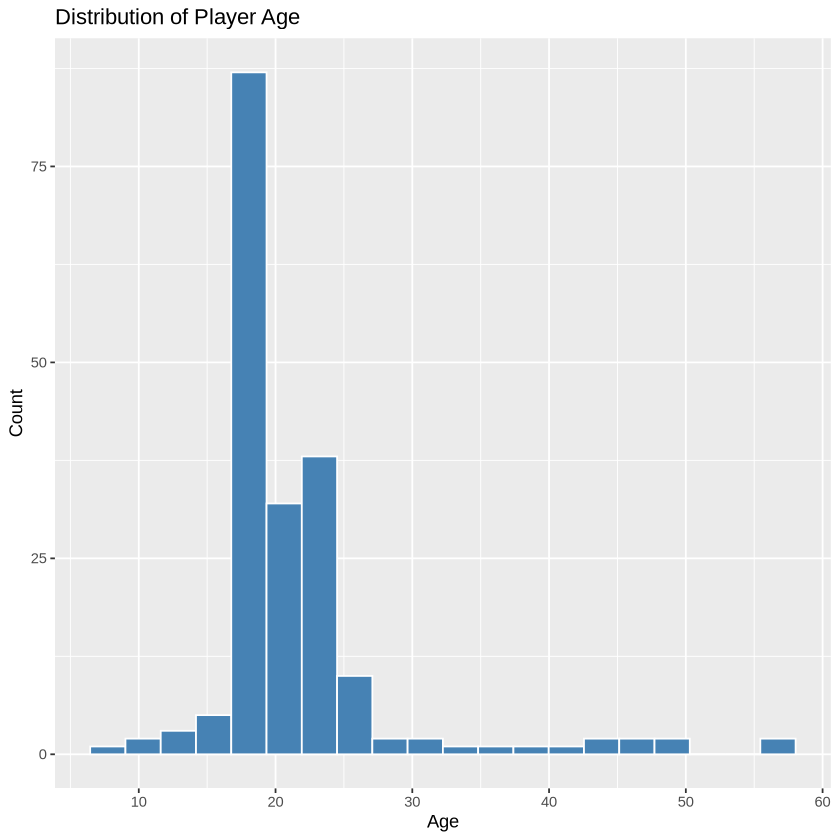

In [44]:
player_age_hist <- players |>
  ggplot(aes(x = Age)) +
  geom_histogram(bins = 20, fill = "steelblue", color = "white") +
  labs(
    title = "Distribution of Player Age",
    x = "Age",
    y = "Count")

player_age_hist

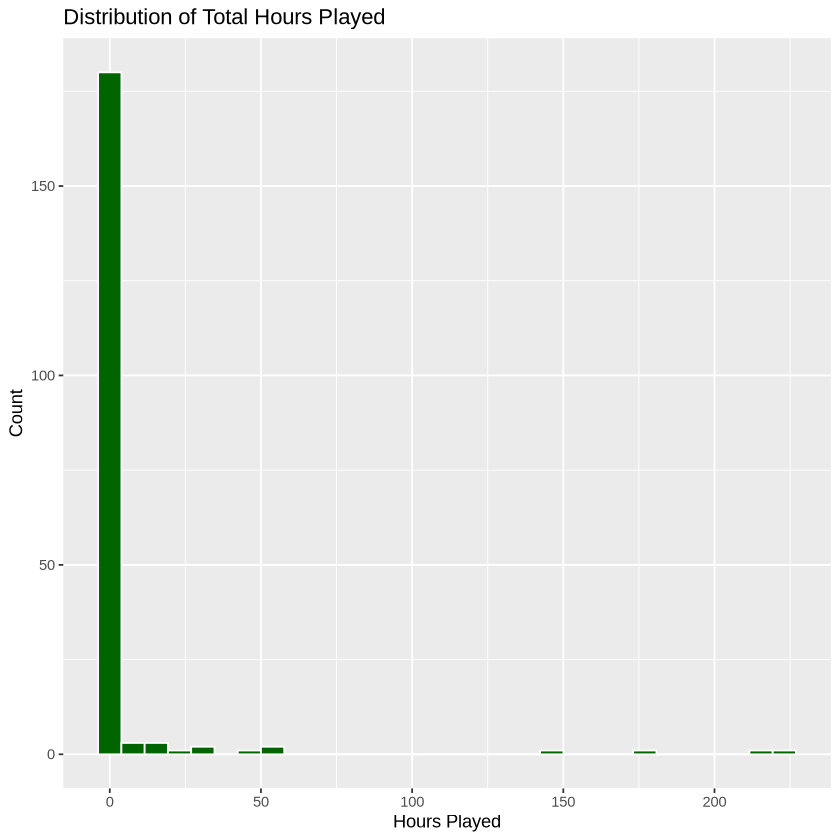

In [45]:
player_hour_hist <- players |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(bins = 30, fill = "darkgreen", color = "white") +
  labs(
    title = "Distribution of Total Hours Played",
    x = "Hours Played",
    y = "Count")

player_hour_hist

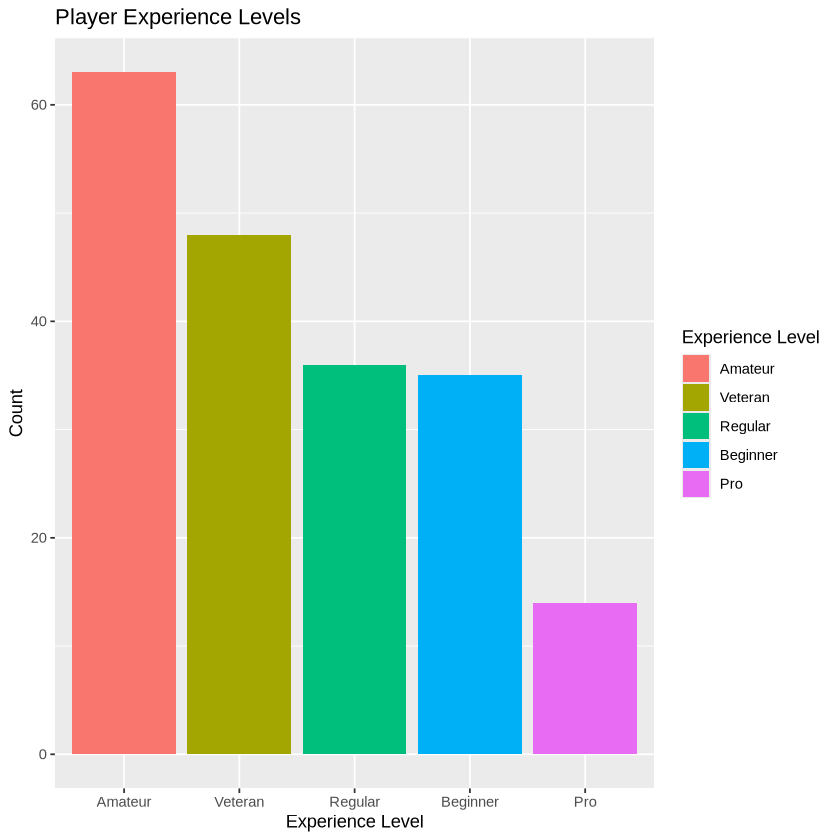

In [65]:
player_experience_bar <- players |>
  mutate(experience = factor(experience, c("Amateur", "Veteran", "Regular", "Beginner", "Pro"))) |>
  ggplot(aes(x = experience, fill = experience)) +
  geom_bar() +
  labs(
    title = "Player Experience Levels",
      fill = "Experience Level",
    x = "Experience Level",
    y = "Count")

player_experience_bar

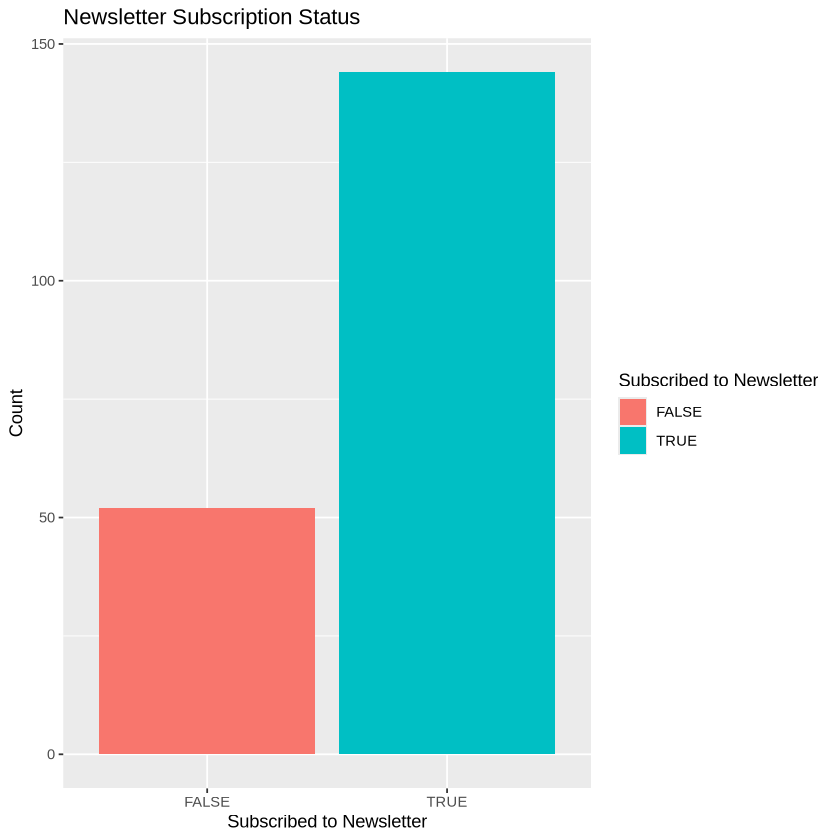

In [60]:
player_sub_status <- players |>
  ggplot(aes(x = subscribe, fill = subscribe)) +
  geom_bar() +
  labs(
    title = "Newsletter Subscription Status",
    fill = "Subscribed to Newsletter",
    x = "Subscribed to Newsletter",
    y = "Count")

player_sub_status

<h1>4) Methods and Plan</h1>
<h3>Proposed Method: K-NN Classification</h3>

<i>Q: Why is this method appropriate?</i> <br><br>
Our problem is a binary classification task, as we are only predicting true or false. Given our small number of predictors and strong dataset size, K-NN is computationally feasible, and requires few assumptions about the underlying data distribution.


<i>Q: Which assumptions are required, if any, to apply the method selected?</i> <br><br>
K-NN is highly sensitive to the scale of features. Because distance is calculated using variables like <code>Age</code> (range ~9-58) and <code>played_hours</code> (range ~0-223), an unstandardized analysis of this data would make the <code>played_hours</code> variable dominate the distance calculation. Thus, we <strong>must</strong> normalize/scale all quantitative features to a similar range.

<i> Q: What are the potential limitations or weaknesses of the method selected?</i> <br><br>
We must choose an optimal *K* value, which can be tricky. A poor choice of *K* can lead to overfitting or underfitting, resulting in a weaker model. Another weakness arises when considering the opportunity cost of using K-NN: it doesn't produce a simple "model" (like regression coefficients), making it slightly less interpretable in terms of which features are most important.

<i> Q: How are you going to compare and select the model?</i> <br><br>
We will tune *K* using 10-fold cross-validation on the training set. After testing on a range of *K* values (starting off with a range akin to 1-30), we can determine the strongest model by picking the *K* value with highest mean cross-validation accuracy.

<i> Q: How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?</i> <br><br>
First, split the <code>players.csv</code> data into a training set (80% of data) and a test set (20% of data) using <code>initial_split</code>. Now that the data is split, we can define a recipe, and convert <code>subscribe</code> to a factor (it is the response variable!). Scale and center our data to prevent variables from having more weight in the voting process of K-NN. <br><br>
Next, define a K-NN model specification using <code>nearest_neighbor()</code>, setting <code>mode = "classification"</code> and <code>neighbors = tune()</code> to mark *K* for tuning. Combine the recipe and the model into a workflow, then begin tuning with <code>tune_grid()</code> and 10 cross-validation folds of the training data. After finding the best *K*, test the model's accuracy on the unseen test set, and report the accuracy, precision, recall, and a confusion matrix for a full picture of its performance.
